In [16]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [17]:
img_rows=28
img_cols=28
channels=1
img_shape=(img_rows, img_cols, channels)

In [18]:
def build_generator():
    noise_shape=(100,)
    
    model=Sequential()
    
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()
    
    noise=Input(shape=noise_shape)
    img=model(noise)
    
    return Model(noise, img)

In [19]:
def build_discriminator():
    
    model=Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    img=Input(shape=img_shape)
    validity=model(img)
    
    return Model(img, validity)

In [20]:
def train(epochs, batch_size=128, save_interval=500):
    (X_train, _), (_, _)=mnist.load_data() #load real images of unisigned intgeers
    X_train=(X_train.astype(np.float32)-127.5)/127.5 #rescale them between -1 to 1
    X_train=np.expand_dims(X_train, axis=3)
    half_batch=int(batch_size/2) #half of gen and real imgs go to discriminator
    
    for epoch in range(epochs):
        idx=np.random.randint(0, X_train.shape[0], half_batch) #take random half batch
        imgs=X_train[idx]
        
        noise=np.random.normal(0, 1, (half_batch, 100)) #100 dimensional noise values
        
        gen_imgs=generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) #y value set to 1 for real images
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) #y value set to 0 for fake images
        
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake) #avg of real and fake
        #train generator
        noise=np.random.normal(0, 1, (batch_size, 100))
        
        valid_y = np.array([1]*batch_size) #generates an array of all 1s in column format
        
        g_loss = combined.train_on_batch(noise, valid_y)
        
        print("%d [D loss: %f, acc.: %.2f%%][G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        g_loss_val.append(g_loss)
        d_loss_val.append(d_loss[0])
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [21]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r*c, 100)) #generate 25 images of the saved images
    gen_imgs = generator.predict(noise)
    
    gen_imgs = .5*gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :,0], cmap='gray')
            axs[i,j].axis('off')
            cnt+=1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [22]:
optimizer= Adam(0.0002, 0.5)

discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#binary crossentropy works better than mean cross error 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [23]:
generator=build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                     

In [24]:
z=Input(shape=(100,))
img=generator(z)

In [25]:
discriminator.trainable=False

In [26]:
valid=discriminator(img)

In [27]:
combined=Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [28]:
g_loss_val = []
d_loss_val = []

In [30]:
train(epochs=1000, batch_size=32, save_interval=1000)

1/1 [==============================] - 0s 12ms/step
0 [D loss: 0.585138, acc.: 81.25%][G loss: 0.844508]
1/1 [==============================] - 0s 10ms/step
1 [D loss: 0.644124, acc.: 59.38%][G loss: 0.782866]
1/1 [==============================] - 0s 9ms/step
2 [D loss: 0.648102, acc.: 59.38%][G loss: 0.727324]
1/1 [==============================] - 0s 10ms/step
3 [D loss: 0.619025, acc.: 59.38%][G loss: 0.753841]
1/1 [==============================] - 0s 9ms/step
4 [D loss: 0.620492, acc.: 56.25%][G loss: 0.758011]
1/1 [==============================] - 0s 10ms/step
5 [D loss: 0.637878, acc.: 56.25%][G loss: 0.784111]
1/1 [==============================] - 0s 10ms/step
6 [D loss: 0.591610, acc.: 68.75%][G loss: 0.820678]
1/1 [==============================] - 0s 10ms/step
7 [D loss: 0.621670, acc.: 62.50%][G loss: 0.834816]
1/1 [==============================] - 0s 10ms/step
8 [D loss: 0.637879, acc.: 59.38%][G loss: 0.843094]
1/1 [==============================] - 0s 9ms/step
9 [D l

In [31]:
generator.save("generator_model_test.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
print(g_loss_val)

[1.0819730758666992, 0.9890890717506409, 1.0513205528259277, 1.2082600593566895, 1.2909446954727173, 1.4442994594573975, 1.533581256866455, 1.7049492597579956, 1.8002315759658813, 1.9396066665649414, 2.0093793869018555, 2.148012161254883, 2.194864273071289, 2.4138717651367188, 2.4407713413238525, 2.680509567260742, 2.588130235671997, 2.7630319595336914, 2.848501682281494, 2.8576464653015137, 2.8064911365509033, 2.920253038406372, 2.956331253051758, 3.0429816246032715, 3.1732177734375, 3.1781270503997803, 3.3673744201660156, 3.2760744094848633, 3.3325037956237793, 3.422891616821289, 3.384732246398926, 3.4717154502868652, 3.5062010288238525, 3.4142518043518066, 3.5951919555664062, 3.630565643310547, 3.6126151084899902, 3.6829004287719727, 3.6844730377197266, 3.7949981689453125, 3.8311574459075928, 3.7955708503723145, 3.791614055633545, 3.8507180213928223, 3.8428263664245605, 3.98795223236084, 4.167657852172852, 3.9705288410186768, 3.952420234680176, 3.9861912727355957, 4.0965800285339355

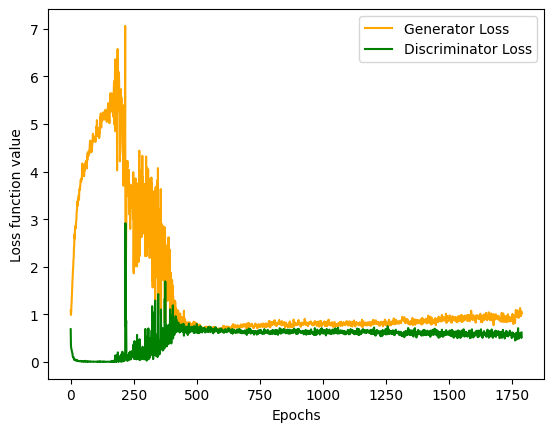

In [34]:
plt.plot(g_loss_val, "orange", label = "Generator Loss")
plt.plot(d_loss_val, "green", label = "Discriminator Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.savefig("Digit.png", format = "png", dpi = 1200)
plt.show()